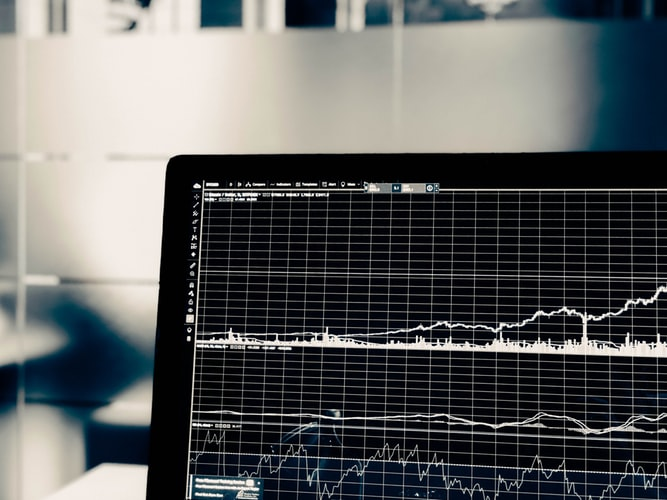

**Time Series Analysis Basics and ARIMA model**

I have collected materials to understand stationarity and other time series aspects in this kernal.

Below are references for the same:
1. [Pierian_Data Josh Portilla time Serie course at Udemy.com](https://www.udemy.com/share/101WWMBEEYc15TQHw=/)
2. Forasting: Principles and Practice by Rob J Hyndman and George Anthanasopoulos
Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 24-03-2020



### ARIMA

**ARIMA MODEL IS COMBINATION OF THREE DIFFERENT APPROACHES** .

ARIMA, or Autoregressive Integrated Moving Average is actually a combination of 3 models:

AR(p) Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period

I(d) Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary

MA(q) Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

**Once we understand the components, we'll investigate how to best choose the  𝑝 ,  𝑑  and  𝑞  values required by the model**

**------------------------------------------------------------------------------------------------------------------------**

**Stationarity and differencing**
Stationary means when the data at a given time does not have corelation with same lag of time of Data at different time. What does it means suppose we have two years of Data . If the value at the month of Jun does not have a corelation on value at next year Jun that means the series is stationary. The statinary Series can have cycles , ups and downs but no trend and sesonality. 

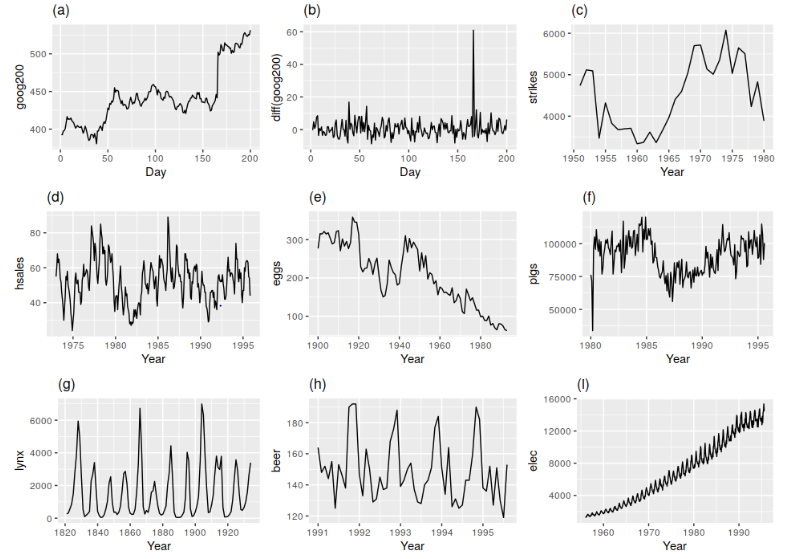

The curve b , h and g have stationarity rest others are are not stationary 

Lets Check One Example

In [ ]:
import pandas as pd

In [ ]:
trade = pd.read_csv('../input/tradein/TradeInventories.csv',index_col=0,parse_dates=True)
trade.index.freq='MS'

In [ ]:
trade.head()

In [ ]:
%matplotlib inline

In [ ]:
trade['Inventories'].plot(figsize=(12,5))

Certainly the above series is not Stationary To convert a non Stationary series into a Stationary series we do Differencing 
Difference means takeing taking the difference of value of next time unit with previous time unit value... However since the first observation can take part in this process , the data gets reduced by 1 observation

In [ ]:
from statsmodels.tsa.statespace.tools import diff

In [ ]:
trade['d1'] = diff(trade['Inventories'],k_diff=1)

In [ ]:
trade['d1'].plot(figsize=(12,5))

**The Above data looks stationary but we have a statistical tool to check for stationarity of the Time seties which is called Dickey-Fuller Test**

## the augmented Dickey-Fuller Test
A test to check the stationarity of time series

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(trade['Inventories'],title='DF for orignal data')

In [ ]:
adf_test(trade['d1'],title='DF for 1 diff data')

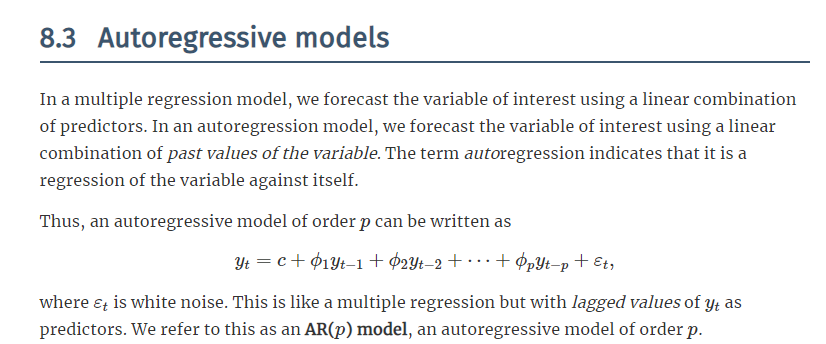

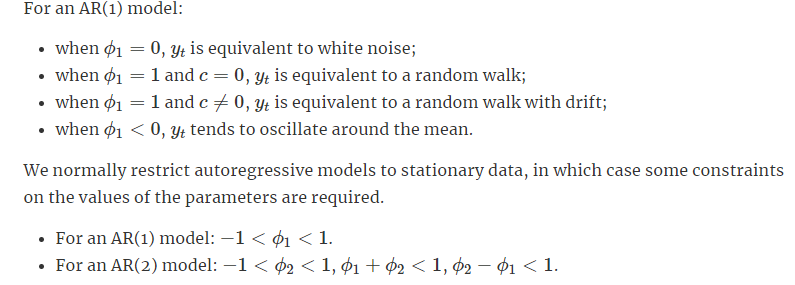

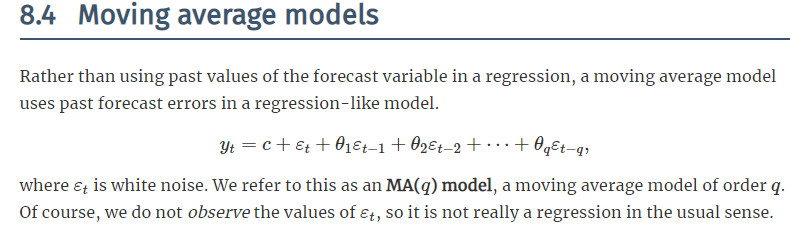

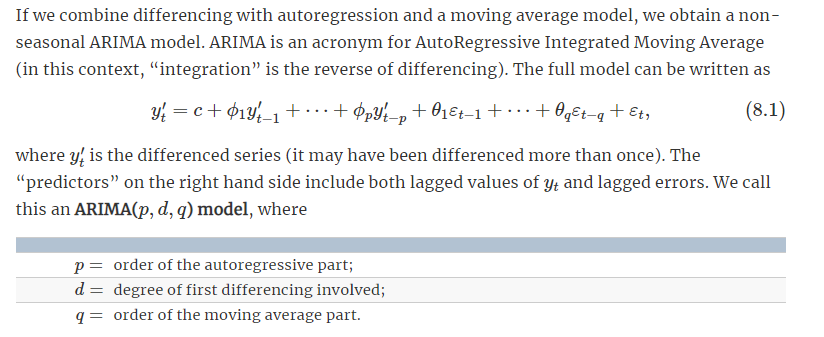

# ACF and PACF
# Autocorrelation Function / Partial Autocorrelation Function

ACF is the autocorelation between the time laged value of time series while PACF is partial autocorelation between the lags removing the effect of other lags.

ACF and PACF can be helpful in finding the ARIMA (p,d,0) model or ARIMA(0,d,q) models but for combine P,d,q model is become very difficult to identify through these plots

The data may follow an ARIMA( p, d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

the ACF is exponentially decaying or sinusoidal;
there is a significant spike at lag  p in the PACF, but none beyond lag p.

The data may follow an ARIMA(0,d,q) model if the ACF and PACF plots of the differenced data show the following patterns:

the PACF is exponentially decaying or sinusoidal;
there is a significant spike at lag q in the ACF, but none beyond lag q
 .

In [ ]:
import numpy as np
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df2 = pd.read_csv('../input/tradein/TradeInventories.csv',index_col=0,parse_dates=True)
df2.index.freq='MS'

In [ ]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [ ]:
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['Inventories'],k_diff=1)

adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

In [ ]:
title = 'Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_acf(df2['Inventories'],title=title,lags=lags);

In [ ]:
title = 'Partial Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_pacf(df2['Inventories'],title=title,lags=lags);

In [ ]:
len(df2)

In [ ]:
# Set one year for testing
train = df2.iloc[:252]
test = df2.iloc[252:]

In [ ]:
model = ARIMA(train['Inventories'],order=(1,1,0))
results = model.fit()
results.summary() 

In [ ]:
model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

In [ ]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

In [ ]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Inventories'][i]}")

In [ ]:
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel=''

ax = test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

**Evaluating the results**

In [ ]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

### Forecasting

In [ ]:
model = ARIMA(df2['Inventories'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

In [ ]:
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel=''

ax = df2['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Seasonality

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
result.plot();

In [ ]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

In [ ]:
df = pd.read_csv('../input/airline1/airline_passengers.csv',index_col=0, parse_dates=True)
df.index.freq='MS'

In [ ]:
df.head()

In [ ]:
month_plot(df['Thousands of Passengers']);

The Auto Arima is not getting installed but it can  be used to find whitch ARIMA( p,d,q) can be best fit for the data

In [ ]:
# !!pip install pyramid-arima
from pmdrima import auto_arima

In [ ]:
stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

In [ ]:
stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=4,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

In [ ]:
stepwise_fit = auto_arima(df['Thousands of Passengers'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()